In [2]:
#importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, mean_absolute_error

from scipy.io import loadmat

import earthpy.plot as ep
import earthpy.spatial as es

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tqdm import tqdm
from numpy.random import seed
from time import time

In [4]:
#loading datasets
salinas = loadmat("/content/Salinas_corrected.mat")["salinas_corrected"]

groundtruth = loadmat("/content/Salinas_gt.mat")["salinas_gt"]

In [5]:
#shape of the dataset
print("Salinas Shape:", salinas.shape)

print("Number of Bands:", salinas.shape[-1])

Salinas Shape: (512, 217, 204)
Number of Bands: 204


In [6]:
#reshapes the salinas array into a 2D array with dimensions

salinas_new = pd.DataFrame(salinas.reshape(salinas.shape[0]*salinas.shape[1], -1))

salinas_new.columns = [f"band{i}" for i in range(1, salinas_new.shape[-1]+1)]

salinas_new["class"] = groundtruth.ravel()

In [7]:
salinas_new.head()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band196,band197,band198,band199,band200,band201,band202,band203,band204,class
0,290,381,585,1041,1316,1397,1319,1462,1643,1683,...,96,109,93,54,79,54,36,11,17,0
1,290,381,519,1041,1316,1352,1319,1462,1643,1683,...,94,111,96,56,83,56,36,11,15,0
2,290,381,585,1041,1286,1352,1300,1412,1614,1644,...,88,107,89,54,81,54,30,11,11,0
3,290,381,585,999,1316,1374,1280,1380,1584,1631,...,86,105,85,56,75,50,30,11,19,0
4,219,381,585,999,1286,1352,1261,1396,1555,1618,...,83,105,83,48,75,50,24,9,17,0


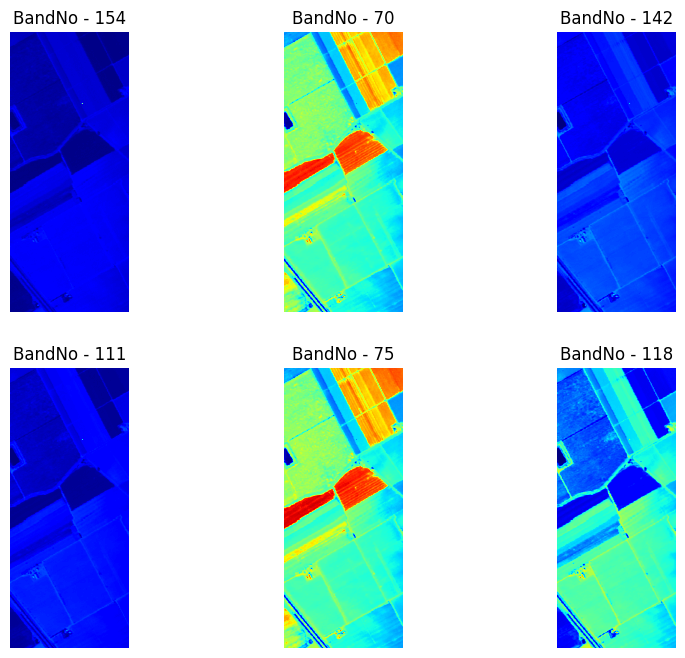

In [8]:
#plotting the bands

fig = plt.figure(figsize = (10, 8))
for i in range(1, 7):
    fig.add_subplot(2,3, i)
    q = np.random.randint(salinas.shape[2])
    plt.imshow(salinas[:,:,q], cmap = "jet")
    plt.axis("off")
    plt.title(f"BandNo - {q}")

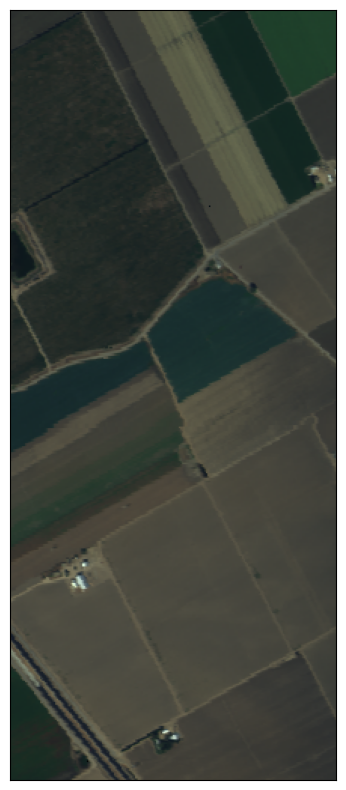

In [9]:
#visualize RGB
mdata = np.moveaxis(salinas, -1, 0)

ep.plot_rgb(mdata, (29, 19, 9), figsize = (10, 10)) 

plt.show()

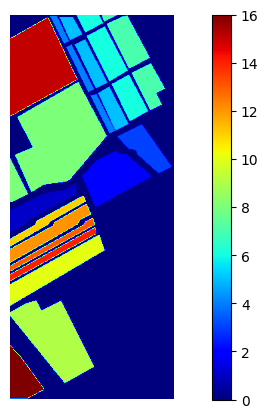

In [10]:
#visualizing of groundtruth
def plot_data(groundtruth):
    
    fig = plt.figure(figsize = (10, 5))
    plt.imshow(groundtruth, cmap = "jet")
    plt.colorbar()
    plt.axis("off")
    plt.show()

plot_data(groundtruth)

In [11]:
#feature scaling

scaling = salinas_new[salinas_new["class"]!= 0]

ind = ["band"+str(i) for i in range(1, scaling.shape[-1])]

X = scaling.loc[:, ind]

y = to_categorical(scaling.loc[:, "class"])

X_scaled = minmax_scale(X, axis = 0);

In [12]:
X_scaled.shape, y.shape

((54129, 204), (54129, 17))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.30, stratify = y)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37890, 204), (16239, 204), (37890, 17), (16239, 17))

In [15]:
ip_shape = X_train[1].shape

n_outputs = y_train.shape[1]

X_train[1].ravel().shape

(204,)

In [16]:
X_train = X_train.reshape(-1, 204, 1)
X_test = X_test.reshape(-1, 204, 1)

In [17]:
model = Sequential(name = "Salinas_CNN_Model")

model.add(Conv1D(filters = 64, kernel_size = 3, activation = "relu", input_shape = (ip_shape[0],1), name = "Layer1"))
model.add(Conv1D(filters = 64, kernel_size = 3, activation = "relu" , name = "Layer2"))
model.add(Conv1D(filters = 64, kernel_size = 3, activation = "relu" , name = "Layer3"))

model.add(MaxPooling1D(pool_size = 2, name = "MaxPooling_Layer1"))
model.add(Dropout(0.4, name = "Dropout1"))

model.add(Conv1D(filters = 32, kernel_size = 3, activation = "relu", name = "Layer4"))
model.add(Conv1D(filters = 32, kernel_size = 3, activation = "relu", name = "Layer5"))
model.add(Conv1D(filters = 32, kernel_size = 3, activation = "relu", name = "Layer6"))

model.add(MaxPooling1D(pool_size = 2, name = "MaxPooling_Layer2"))
model.add(Dropout(0.4, name = "Dropout2"))

model.add(Flatten(name = "Flatten"))
model.add(Dense(25, activation= "relu", name = "DenseLayer"))

model.add(Dense(n_outputs, activation= "softmax", name = "OutputLayer"))


In [18]:
model.summary()

Model: "Salinas_CNN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer1 (Conv1D)             (None, 202, 64)           256       
                                                                 
 Layer2 (Conv1D)             (None, 200, 64)           12352     
                                                                 
 Layer3 (Conv1D)             (None, 198, 64)           12352     
                                                                 
 MaxPooling_Layer1 (MaxPooli  (None, 99, 64)           0         
 ng1D)                                                           
                                                                 
 Dropout1 (Dropout)          (None, 99, 64)            0         
                                                                 
 Layer4 (Conv1D)             (None, 97, 32)            6176      
                                                 

In [19]:
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [20]:
early_stop = EarlyStopping(monitor = "val_loss",
                           min_delta = 0,
                           patience = 10,
                           mode = "min",
                           verbose = 1,
                           restore_best_weights = True)

In [21]:
checkpoint = ModelCheckpoint(filepath = "Salinas_Model.h5", 
                             monitor = "val_loss", 
                             mode = "min",
                             verbose = 1,
                             save_best_only = True)


In [22]:
tensorboard = TensorBoard(log_dir = "SA_logs/{}".format(time()))

In [23]:
history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test), 
                    epochs = 100,
                    batch_size = 256,
                    callbacks = [early_stop, checkpoint, tensorboard])

Epoch 1/100
149/149 [==============================] - ETA: 0s - loss: 1.5184 - accuracy: 0.4917
Epoch 1: val_loss improved from inf to 0.74728, saving model to Salinas_Model.h5
149/149 [==============================] - 17s 19ms/step - loss: 1.5184 - accuracy: 0.4917 - val_loss: 0.7473 - val_accuracy: 0.6998
Epoch 2/100
146/149 [============================>.] - ETA: 0s - loss: 0.6950 - accuracy: 0.7230
Epoch 2: val_loss improved from 0.74728 to 0.54621, saving model to Salinas_Model.h5
149/149 [==============================] - 2s 13ms/step - loss: 0.6929 - accuracy: 0.7243 - val_loss: 0.5462 - val_accuracy: 0.7725
Epoch 3/100
146/149 [============================>.] - ETA: 0s - loss: 0.5419 - accuracy: 0.7859
Epoch 3: val_loss improved from 0.54621 to 0.44452, saving model to Salinas_Model.h5
149/149 [==============================] - 2s 13ms/step - loss: 0.5409 - accuracy: 0.7862 - val_loss: 0.4445 - val_accuracy: 0.8255
Epoch 4/100
148/149 [============================>.] - ETA: 0

In [24]:
y_pred = model.predict(X_test)

508/508 [==============================] - 1s 2ms/step


In [25]:
score = model.evaluate(X_test, y_test, verbose = 0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.20309282839298248
Test accuracy: 0.9186526536941528


Text(0, 0.5, 'accuracy')

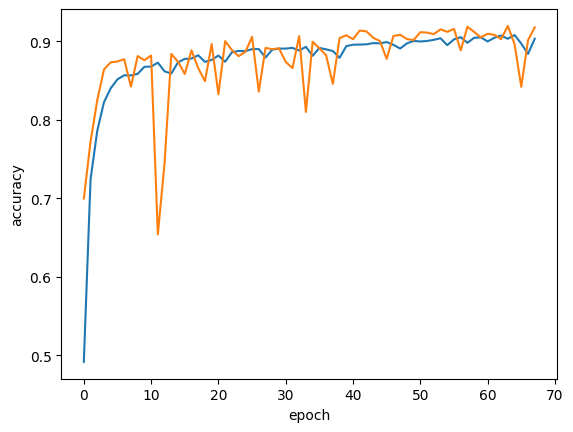

In [26]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("epoch")
plt.ylabel("accuracy")


Text(0, 0.5, 'loss')

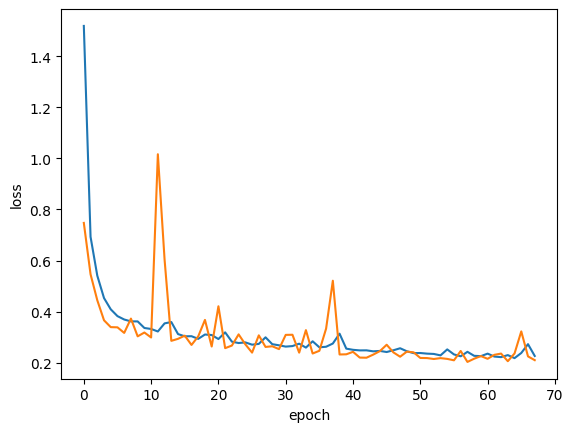

In [27]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")

In [28]:
pred = np.argmax(model.predict(X_test), axis = 1)

# Classification Report
print(classification_report(pred, np.argmax(y_test, 1),
        target_names = ["Brocoli_green_weeds_1", "Brocoli_green_weeds_2", "Fallow", "Fallow_rough_plow", "Fallow_smooth", "Stubble", "Celery", "Grapes_untrained", "Soil_vinyard_develop", "Corn_senesced_green_weeds", "Lettuce_romaine_4wk", "Lettuce_romaine_5wk", "Lettuce_romaine_6wk", "Lettuce_romaine_7wk", "Vinyard_untrained", "Vinyard_vertical_trellis"]))

508/508 [==============================] - 1s 2ms/step
                           precision    recall  f1-score   support

    Brocoli_green_weeds_1       0.99      1.00      0.99       596
    Brocoli_green_weeds_2       1.00      0.99      1.00      1124
                   Fallow       1.00      0.95      0.98       621
        Fallow_rough_plow       1.00      0.99      1.00       420
            Fallow_smooth       0.99      0.99      0.99       803
                  Stubble       1.00      1.00      1.00      1185
                   Celery       0.99      1.00      1.00      1065
         Grapes_untrained       0.87      0.80      0.83      3694
     Soil_vinyard_develop       1.00      0.99      0.99      1868
Corn_senesced_green_weeds       0.93      0.93      0.93       982
      Lettuce_romaine_4wk       0.98      0.96      0.97       325
      Lettuce_romaine_5wk       1.00      0.97      0.99       594
      Lettuce_romaine_6wk       0.99      0.96      0.98       283
      

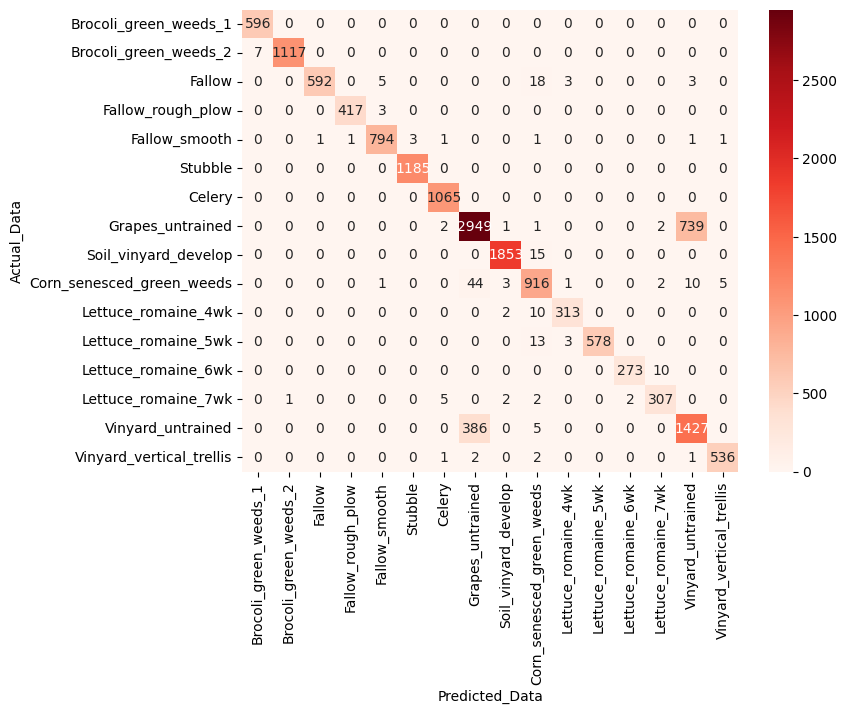

In [29]:
plt.figure(figsize = (8,6))

classes = ["Brocoli_green_weeds_1", "Brocoli_green_weeds_2", "Fallow", "Fallow_rough_plow", "Fallow_smooth", "Stubble", "Celery", "Grapes_untrained", "Soil_vinyard_develop", "Corn_senesced_green_weeds", "Lettuce_romaine_4wk", "Lettuce_romaine_5wk", "Lettuce_romaine_6wk", "Lettuce_romaine_7wk", "Vinyard_untrained", "Vinyard_vertical_trellis"]

c_matrix = confusion_matrix(np.add(pred, 1), np.add(np.argmax(y_test, 1), 1))

df_cmatrix = pd.DataFrame(c_matrix, index = classes, columns = classes)

df_cmatrix.index.name = "Actual_Data"
df_cmatrix.columns.name = "Predicted_Data"

sns.heatmap(df_cmatrix, annot = True, annot_kws = {"size": 10}, fmt= "d", cmap = "Reds")

plt.show()

In [30]:
import math
MSE = np.square(np.subtract(y_test, y_pred)).mean() 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n", RMSE)

Root Mean Square Error:
 0.08414738936050829


In [31]:
print("Mean Absolute Error (MAE)", mean_absolute_error(y_test, y_pred))

Mean Absolute Error (MAE) 0.014922363


3472/3472 [==============================] - 8s 2ms/step


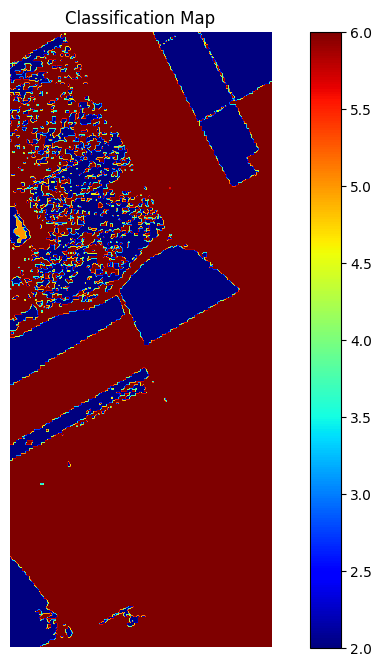

In [32]:
#predict class labels for the entire salinas image
salinas_pred = model.predict(salinas_new[ind].values.reshape(-1, 204, 1))

#reshape the predicted labels to the original image dimensions
salinas_pred = salinas_pred.argmax(axis=1).reshape(salinas.shape[0], salinas.shape[1])

#plot the classification map
plt.figure(figsize=(10,8))
plt.imshow(salinas_pred, cmap = "jet")
plt.colorbar()
plt.axis("off")
plt.title("Classification Map")
plt.show()